In [86]:
!pip install pgmpy
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import BicScore, K2Score
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from pgmpy.inference import VariableElimination, ApproxInference
import matplotlib.pyplot as plt
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from tabulate import tabulate
import itertools
import time



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
df = pd.read_csv("/content/drive/MyDrive/cleaning_dataset.csv")
df = df.drop(['Gender'],axis= 1)
print(df.shape)
df.head()

(1470, 13)


,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,PerformanceRating,TotalWorkingYears,WorkLifeBalance
0,Senior,Yes,Rarely,Short,College,Rappresentative,Very_high,Single,On_average,Yes,Excellent,Competent,Bad
1,Senior,No,Frequently,Short,Below_college,Rappresentative,Medium,Married,On_average,No,Outstanding,Competent,Better
2,Middle-age,Yes,Rarely,Short,College,Technician,High,Single,Lower,Yes,Excellent,Competent,Better
3,Middle-age,No,Frequently,Short,Master,Technician,High,Married,Lower,Yes,Excellent,Competent,Better
4,Young,No,Rarely,Short,Below_college,Technician,Medium,Married,Lower,No,Excellent,Beginner,Better


# Hand-made net
The aim is to build a network whose dipendencies relations are defined by us and confirmed  from the chi-square test. The main idea is to follow a casual-effect order, in particular starting from the personal and job information of the employees to the effect of the jobs performed. 
The approch is summarized in the following points:


1.   Defining an order of the random variables
2.   Defining the edges partially based on the chi square 
3.   Building the net



# 1

In [ ]:
orderd_list = ['Age','Education','MaritalStatus','DistanceFromHome','BusinessTravel',
               'WorkLifeBalance','TotalWorkingYears','JobLevel','OverTime','JobSatisfaction',
               'PerformanceRating','MonthlyIncome','Attrition']

# 2


In [ ]:
edges = [("Age","TotalWorkingYears"), 
         ("Age","JobLevel"), #dato dal chi square
         ("Education","JobLevel"),
         ("MaritalStatus","WorkLifeBalance"),
         ("MaritalStatus","BusinessTravel"),
         ("MaritalStatus","OverTime"),
         ("DistanceFromHome","WorkLifeBalance"),
         ("DistanceFromHome","JobSatisfaction"),
         ("WorkLifeBalance","Attrition"),
         ("BusinessTravel","OverTime"),
         ("BusinessTravel","WorkLifeBalance"),
         ("OverTime","MonthlyIncome"),
         ("OverTime","Attrition"),
         ("OverTime","PerformanceRating"),
         ("JobLevel","MonthlyIncome"),
         ("JobLevel","JobSatisfaction"),
         ("JobSatisfaction","PerformanceRating"),
         ("JobSatisfaction","Attrition"),
         ("TotalWorkingYears","JobLevel"),
         ("TotalWorkingYears","MonthlyIncome"),
         ("PerformanceRating","MonthlyIncome"),
         ]

# 3

Number of edges: 21


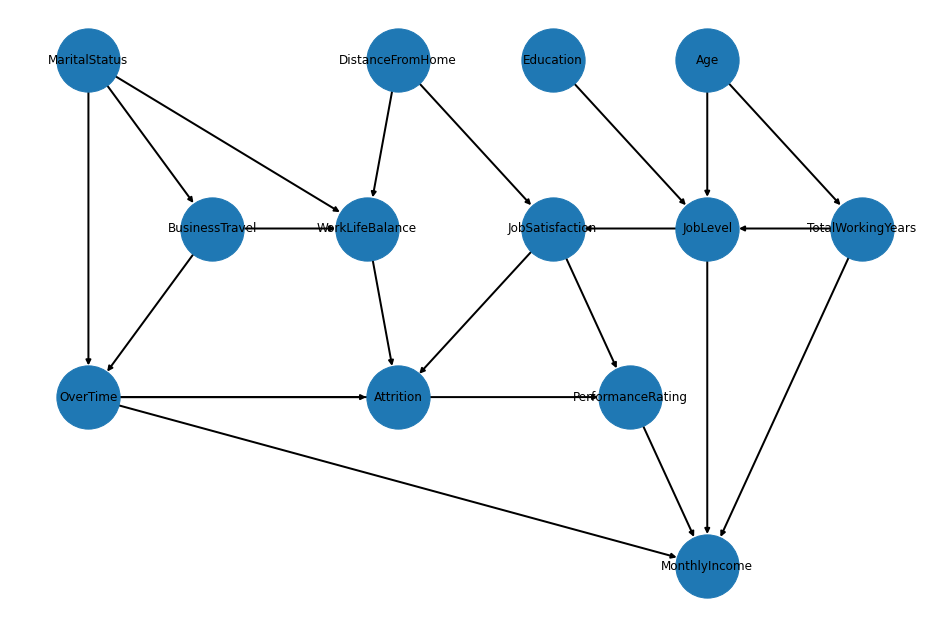

In [79]:
hand_net = BayesianNetwork(edges)
plt.figure(figsize=(13,8.5))
pos = {
     "MaritalStatus":(1,5),
     "DistanceFromHome":(3,5),
     "Education":(4,5),
     "Age":(5,5),
     "OverTime":(1,1),
     "BusinessTravel":(1.8,3),
     "WorkLifeBalance":(2.8,3),
     "JobSatisfaction":(4,3),
     "JobLevel":(5,3),
     "TotalWorkingYears":(6,3),
     "PerformanceRating":(4.5,1),
     "MonthlyIncome":(5,-1),
     "Attrition":(3,1),
}
print("Number of edges: " + str(len(edges)))
nx.draw(hand_net,pos=pos, with_labels=True, node_size=4000, width=2, arrowsize=10 )



# Refinings NON VA BENE
To improve the  network just obtained we apply the HillClimb algorithm in order to highlight the dependencies which may emerge from the dataset. This way the algorithm removes and adds edges to reach the best value of the BicScore parameter. 
Moreover we consider a black list of edges the algorithm can't use, this list is obtained following the general rule of the belief networks:
P(x|parents(x)) this way the algorithm  stricly follows the order we imposed to the random variables.

In [87]:
black_list = []
for i in range(len(orderd_list)):
    for j in range(0, i):
        black_list.append((orderd_list[i],orderd_list[j]))


hillclimbest = HillClimbSearch(df)
starting_net = DAG()
starting_net.add_edges_from(ebunch=edges)#hand-made network
hillclimbmodel = hillclimbest.estimate(scoring_method=K2Score(df), start_dag=starting_net, black_list=black_list, max_iter=100, max_indegree=3)
hillclimb_net = BayesianNetwork(hillclimbmodel.edges)
print("Number of edges:")
print(len(hillclimbmodel.edges))
print("Removed Edges:")
print(edges-hillclimbmodel.edges)
print("Added_edges:")
print(hillclimbmodel.edges-edges)

  0%|          | 0/100 [00:00<?, ?it/s]

Number of edges:
6
Removed Edges:
{('JobLevel', 'JobSatisfaction'), ('WorkLifeBalance', 'Attrition'), ('MaritalStatus', 'WorkLifeBalance'), ('OverTime', 'PerformanceRating'), ('DistanceFromHome', 'WorkLifeBalance'), ('PerformanceRating', 'MonthlyIncome'), ('MaritalStatus', 'BusinessTravel'), ('BusinessTravel', 'OverTime'), ('BusinessTravel', 'WorkLifeBalance'), ('OverTime', 'MonthlyIncome'), ('MaritalStatus', 'OverTime'), ('DistanceFromHome', 'JobSatisfaction'), ('JobSatisfaction', 'Attrition'), ('TotalWorkingYears', 'MonthlyIncome'), ('Education', 'JobLevel'), ('JobSatisfaction', 'PerformanceRating'), ('Age', 'JobLevel')}
Added_edges:
{('Age', 'Education'), ('JobLevel', 'Attrition')}
